#### 1. Load Results Files
Change "PROJECT_ROOT" and "SUBJECT" accordingly 

In [15]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = "C:/Users/hapla/Documents/GitHub/albert-plante_project"
SUBJECT = "0457"

RESULTSDIR = f"{PROJECT_ROOT}/results/results_{SUBJECT}"
TEMPLATE_DIR = f"{PROJECT_ROOT}/data/derivatives/templates"

mp2rage_path = f"{RESULTSDIR}/mp2rage_mni.nii.gz"
t1_map_path = f"{RESULTSDIR}/t1_map_mni.nii.gz"
fa_path = f"{RESULTSDIR}/fa_map_mni.nii.gz"
dwi_path = f"{RESULTSDIR}/dwi_mni.nii.gz"
seg_mp2rage_path = f"{RESULTSDIR}/seg_mp2rage_mni.nii.gz"
seg_dwi_path = f"{RESULTSDIR}/seg_dwi_mni.nii.gz"
seg_atlas_path = f"{TEMPLATE_DIR}/Optic_Nerve_Label_MNI.nii.gz"


mp2rage = nib.load(mp2rage_path).get_fdata()
t1_map= nib.load(t1_map_path).get_fdata()
fa_map = nib.load(fa_path).get_fdata()
dwi = nib.load(dwi_path).get_fdata()
seg_mp2rage = nib.load(seg_mp2rage_path).get_fdata()
seg_dwi  = nib.load(seg_dwi_path).get_fdata()
seg_atlas = nib.load(seg_atlas_path).get_fdata()

#### 2. Extract differents metrics from segmentation masks

In [58]:
def dice_coefficient(mask1, mask2):
    intersection = np.sum(mask1 & mask2)
    size1 = np.sum(mask1)
    size2 = np.sum(mask2)
    if size1 + size2 == 0:
        return np.nan
    return 2 * intersection / (size1 + size2)

num_slices = seg_mp2rage.shape[1]
mask_overlap = (seg_mp2rage > 0) & (seg_dwi > 0)

num_mp2rage = []
num_dwi = []
overlap_counts = []
dice_scores = []
mean_t1 = []
std_t1 = []
mean_fa = []
std_fa = []

for i in range(num_slices):
    seg1_slice = seg_mp2rage[:, i, :] > 0
    seg2_slice = seg_dwi[:, i, :] > 0

    n_mp2rage = np.sum(seg1_slice)
    n_dwi = np.sum(seg2_slice)
    overlap = np.sum(seg1_slice & seg2_slice)
    dice = dice_coefficient(seg1_slice, seg2_slice)

    num_mp2rage.append(n_mp2rage)
    num_dwi.append(n_dwi)
    overlap_counts.append(overlap)
    dice_scores.append(dice)

    overlap_mask_slice = mask_overlap[:, i, :]   
    vals_t1 = t1_map[:, i, :][overlap_mask_slice]
    vals_t1 = vals_t1[vals_t1 > 0]
    vals_fa = fa_map[:, i, :][overlap_mask_slice] / 1000
    vals_fa = vals_fa[vals_fa > 0] 

    if vals_t1.size > 0:
        mean_t1_val = np.mean(vals_t1)
        std_t1_val = np.std(vals_t1)
    else:
        mean_t1_val = np.nan
        std_t1_val = np.nan

    if vals_fa.size > 0:
        mean_fa_val = np.mean(vals_fa)
        std_fa_val = np.std(vals_fa)
    else:
        mean_fa_val = np.nan
        std_fa_val = np.nan

    mean_t1.append(mean_t1_val)
    std_t1.append(std_t1_val)
    mean_fa.append(mean_fa_val)
    std_fa.append(std_fa_val)

df_metrics = pd.DataFrame({
    "slice_index": np.arange(num_slices),
    "num_mp2rage": num_mp2rage,
    "num_dwi": num_dwi,
    "overlap": overlap_counts,
    "dice": dice_scores,
    "mean_t1": mean_t1,
    "std_t1": std_t1,
    "mean_fa": mean_fa,
    "std_fa": std_fa
})

df_filtered = df_metrics[df_metrics["overlap"] > 0].reset_index(drop=True)

#### 3. Compute MVF, FVF, and g-ratio

In [ ]:
mtvf_vals = []
mvf_vals = []
fvf_vals = []
g_ratio_vals = []

mean_vals_t1 = df_filtered["mean_t1"].values
mean_vals_fa = df_filtered["mean_fa"].values

for t1, fa in zip(mean_vals_t1, mean_vals_fa):
    if t1 > 0:
        mtvf = 1 - 1 / ((0.42202 / t1) + 0.94766)
    else:
        mtvf = 0
    mtvf_vals.append(mtvf)

    mvf = 0.5 * mtvf
    mvf_vals.append(mvf)

    fvf = 0.883 * (fa ** 2) - 0.082 * fa + 0.074
    fvf_vals.append(fvf)

    g_ratio = np.sqrt(1 - (mvf / fvf)) if fvf > 0 else np.nan
    g_ratio_vals.append(g_ratio)

df_filtered["MTVF"] = mtvf_vals
df_filtered["MVF"] = mvf_vals
df_filtered["FVF"] = fvf_vals
df_filtered["g_ratio"] = g_ratio_vals

#### 4. Relevant metrics print

In [ ]:
print("=== Segmentation Metrics Summary ===")
print(f"Number of slices analyzed: {len(df_filtered)}")

mean_dice = df_filtered["dice"].mean()
std_dice = df_filtered["dice"].std()
print(f"Dice coefficient: mean = {mean_dice:.4f}, std = {std_dice:.4f}")

mean_overlap = df_filtered["overlap"].mean()
print(f"Average overlapping voxels per slice: {mean_overlap:.1f}")

mean_t1 = df_filtered["mean_t1"].mean()
std_t1 = df_filtered["mean_t1"].std()
print(f"T1 values inside overlap: mean = {mean_t1:.2f} s, std = {std_t1:.2f} s")

mean_fa = df_filtered["mean_fa"].mean()
std_fa = df_filtered["mean_fa"].std()
print(f"FA values inside overlap: mean = {mean_fa:.4f}, std = {std_fa:.4f}")

if "MTVF" in df_filtered.columns:
    mean_mtvf = df_filtered["MTVF"].mean()
    print(f"Mean MTVF: {mean_mtvf:.4f}")

if "MVF" in df_filtered.columns:
    mean_mvf = df_filtered["MVF"].mean()
    print(f"Mean MVF: {mean_mvf:.4f}")

if "FVF" in df_filtered.columns:
    mean_fvf = df_filtered["FVF"].mean()
    print(f"Mean FVF: {mean_fvf:.4f}")

if "g_ratio" in df_filtered.columns:
    mean_g = df_filtered["g_ratio"].mean()
    print(f"Mean g-ratio: {mean_g:.4f}")



=== Segmentation Metrics Summary ===
Number of slices analyzed: 32
Dice coefficient: mean = 0.4961, std = 0.1703
Average overlapping voxels per slice: 20.8
T1 values inside overlap: mean = 0.99 ms, std = 0.13 ms
FA values inside overlap: mean = 0.5886, std = 0.1408
Mean MTVF: 0.2736
Mean MVF: 0.1368
Mean FVF: 0.3486
Mean g-ratio: 0.7329


#### Plots

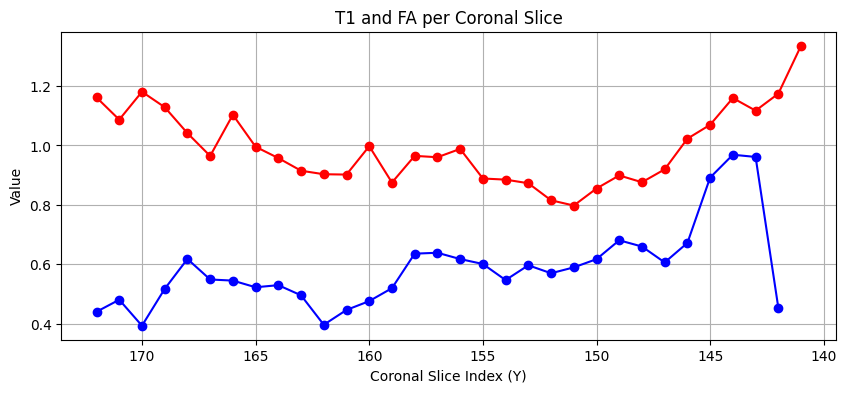

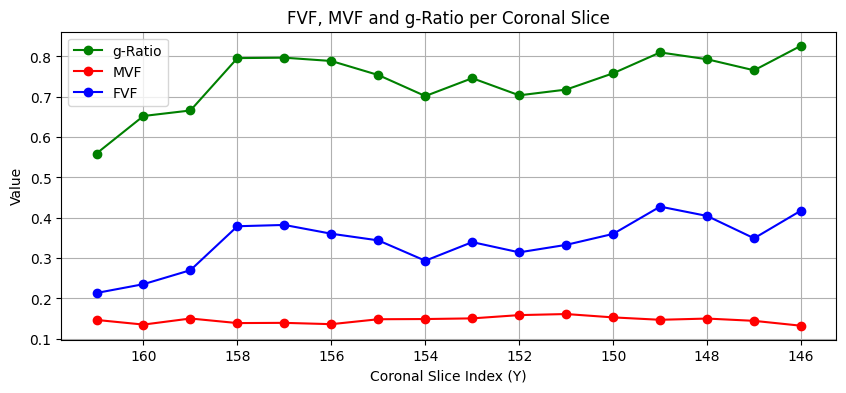

In [67]:
plt.figure(figsize=(10, 4))
plt.plot(df_filtered["slice_index"], df_filtered["mean_t1"], label='T1', marker='o', linestyle='-', color='red')
plt.plot(df_filtered["slice_index"], df_filtered["mean_fa"], label='FA', marker='o', linestyle='-', color='blue')
plt.title("T1 and FA per Coronal Slice")
plt.xlabel("Coronal Slice Index (Y)")
plt.ylabel("Value")
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

selected = df_filtered[(df_filtered["slice_index"] >= 146) & (df_filtered["slice_index"] <= 161)]
plt.figure(figsize=(10, 4))
plt.plot(selected["slice_index"], selected["g_ratio"], label='g-Ratio', marker='o', linestyle='-', color='green')
plt.plot(selected["slice_index"], selected["MVF"], label='MVF', marker='o', linestyle='-', color='red')
plt.plot(selected["slice_index"], selected["FVF"], label='FVF', marker='o', linestyle='-', color='blue')
plt.title("FVF, MVF and g-Ratio per Coronal Slice")
plt.xlabel("Coronal Slice Index (Y)")
plt.ylabel("Value")
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True)
plt.show()